In [1]:
# Initial imports and loading in our data.
# This is (almost) direct from SurveyMonkey, though
# I scrubbed IP addresses and access dates to anonymize.

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('aperture_survey_responses.tsv', sep='\t')

In [2]:
# SurveyMonkey provides an odd nesting of responses when exporting results.
# We'd like to convert this structure to a pandas MultiIndex data frame.
# First, let's find question indices -- adapted from https://stackoverflow.com/a/49584888

indices = [i for i, c in enumerate(df.columns) if not c.startswith('Unnamed')]
slices = [slice(i, j) for i, j in zip(indices, indices[1:] + [None])]
repeats = [len(range(*slice.indices(len(df.columns)))) for slice in slices]

In [3]:
# Now let's grab all of the questions and each of the options provided as possible responses.
questions = [c for c in df.columns if not c.startswith('Unnamed')]
options = df.iloc[:1].values[0].tolist()

# We can pair each possible response with its associated question...
matched_questions = []
for index, question in enumerate(questions):
    matched_questions += [question] * repeats[index]

# ... and create a new dataframe named 'responses' that correctly pairs questions and responses.
index = pd.MultiIndex.from_arrays([matched_questions, options],
                                  names=('question', 'options'))
data = df.iloc[2:].values
responses = pd.DataFrame(data=data, columns=index)

In [4]:
# Optional data cleaning -- remove 'Other' responses for easier plotting.
responses.drop('Other (please specify)',
               axis=1, level=1, inplace=True)
responses.drop('Other',
               axis=1, level=1, inplace=True)
responses.drop('* If you selected other please specify',
               axis=1, level=1, inplace=True)

In [5]:
# First question of interest --
responses['Should OHBM have an official publishing platform?',
          'Response'].value_counts(normalize=True)  # the normalize keyword converts to percentages

Yes    0.865591
No     0.134409
Name: (Should OHBM have an official publishing platform?, Response), dtype: float64

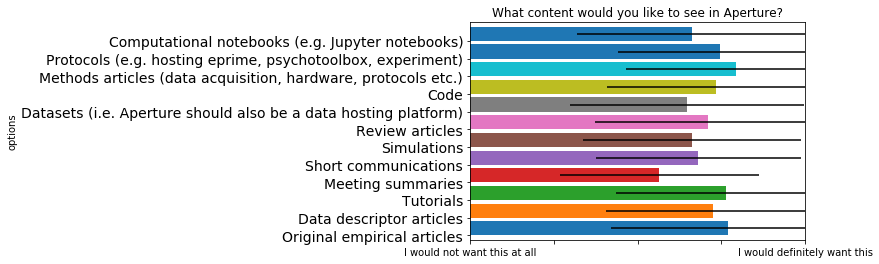

In [6]:
# Next, we'd like to look at want content respondents wanted published in Aperture
# For ease of visualization, I've reverse-coded the values.

content = responses['What content would you like to see in Aperture? \
(1 = would definitely want this, 5 = I would not want this at all)'].astype(float)
content = content.applymap(lambda x: 6 - x)  # Here's where we reverse the scoring

# We're just going to plot the mean value across respondents for ease of intrepretation.
# This is data that's great to dig into, though, if you have more specific questions!

content.mean().plot(kind='barh', title='What content would you like to see in Aperture?',
                    xticks=[], xlim=(1, 5), fontsize=14,
                    position=0, width=.8, xerr=content.std())
plt.xticks(np.arange(1, 6), ('I would not want this at all', '', '', '', 'I would definitely want this'));

On average, respondents were willing to pay $127 per submission to Aperture.
They also indicated they would pay an additional $817 to publish in Aperture.


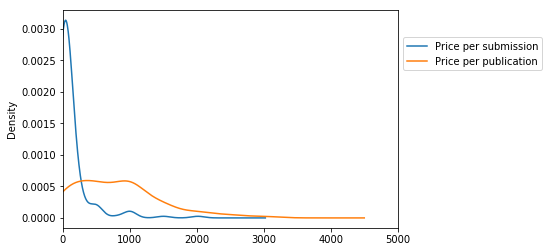

In [7]:
# What are respondents willing to pay to sustain Aperture ?
price_per_sub = pd.to_numeric(responses['Per submission:',
                                        'Open-Ended Response'])
price_per_pub = pd.to_numeric(responses['Per publication:',
                                        'Open-Ended Response'])

# Let's print the average for each of these two responses
print('On average, respondents were willing to pay ${:.0f} per submission to Aperture.'.format(price_per_sub.mean()))
print('They also indicated they would pay an additional ${:.0f} to publish in Aperture.'.format(price_per_pub.mean()))

# Averages can be a little misleading, so let's also look at the distributions
pd.concat([price_per_sub, price_per_pub], axis=1).plot.kde(xlim=[0, 5000]);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8),
           labels=['Price per submission', 'Price per publication']);